In [1]:
try:
    import google.colab  # noqa: F401

    # specify the version of DataEval (==X.XX.X) for versions other than the latest
    %pip install -q dataeval[torch]
except Exception:
    pass

In [2]:
# You will need matplotlib for visualing our dataset and numpy to be able to handle the data.
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.v2 as v2
from numpy.typing import NDArray

# You are only using torchvision to load in the dataset.
# If you already have the data stored on your computer in a numpy friendly manner,
# then feel free to load it directly into numpy arrays.
from torchvision import datasets

# Load the classes from DataEval that are helpful for EDA
from dataeval.detectors.linters import Duplicates, Outliers
from dataeval.metrics.stats import channelstats, datasetstats, hashstats, labelstats

# Set the random value
rng = np.random.default_rng(213)

In [3]:
# Download the data and then load it as a torch Tensor
to_tensor = v2.ToImage()
ds = datasets.VOCDetection(
    "./data",
    year="2011",
    image_set="train",
    download=True,
    transform=to_tensor,
)

Using downloaded and verified file: ./data/VOCtrainval_25-May-2011.tar
Extracting ./data/VOCtrainval_25-May-2011.tar to ./data


In [4]:
# Verify the size of the loaded dataset
len(ds)

5717

In [5]:
# Check the label structure
ds[0][1]

{'annotation': {'folder': 'VOC2011',
  'filename': '2008_000008.jpg',
  'source': {'database': 'The VOC2008 Database',
   'annotation': 'PASCAL VOC2008',
   'image': 'flickr'},
  'size': {'width': '500', 'height': '442', 'depth': '3'},
  'segmented': '0',
  'object': [{'name': 'horse',
    'pose': 'Left',
    'truncated': '0',
    'occluded': '1',
    'bndbox': {'xmin': '53', 'ymin': '87', 'xmax': '471', 'ymax': '420'},
    'difficult': '0'},
   {'name': 'person',
    'pose': 'Unspecified',
    'truncated': '1',
    'occluded': '0',
    'bndbox': {'xmin': '158', 'ymin': '44', 'xmax': '289', 'ymax': '167'},
    'difficult': '0'}]}}

In [6]:
labels = [[o["name"] for o in d[1]["annotation"]["object"]] for d in ds]

labels[0]

['horse', 'person']

In [7]:
# Calculate basic label statistics from the dataset
lstats = labelstats(labels)

# Display basic counts
print(f"Class Count: {lstats.class_count}")
print(f"Label Count: {lstats.label_count}")
print("--------------------------------------")

# Display counts per class
print("     Object: Total Count - Image Count")
for cls in lstats.label_counts_per_class:
    print(f"{cls:>11}:    {lstats.label_counts_per_class[cls]:>4}\
     -    {lstats.image_counts_per_label[cls]:>4}")

Class Count: 20
Label Count: 15774
--------------------------------------
     Object: Total Count - Image Count
  aeroplane:     470     -     328
    bicycle:     410     -     281
       bird:     592     -     399
       boat:     508     -     264
     bottle:     749     -     399
        bus:     317     -     219
        car:    1191     -     621
        cat:     609     -     540
      chair:    1457     -     656
        cow:     355     -     155
diningtable:     373     -     318
        dog:     768     -     636
      horse:     377     -     238
  motorbike:     375     -     274
     person:    5019     -    2142
pottedplant:     557     -     289
      sheep:     509     -     171
       sofa:     399     -     359
      train:     327     -     275
  tvmonitor:     412     -     299


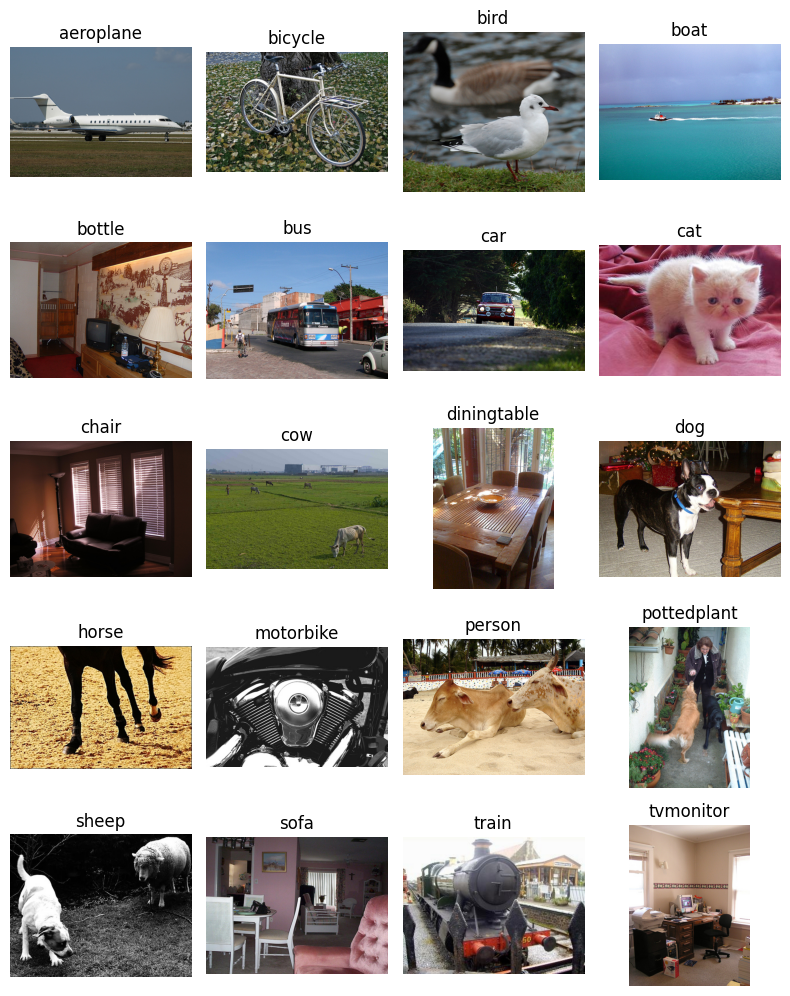

In [8]:
# Helper function to get image and permute to channels last for matplotlib
def get_image(index: int) -> NDArray:
    return np.moveaxis(ds[index][0].numpy(), 0, -1)


# Plot random images from each category
_, axs = plt.subplots(5, 4, figsize=(8, 10))

for ax, (category, indices) in zip(axs.flat, lstats.image_indices_per_label.items()):
    # Randomly select an index from the list of indices
    selected_index = rng.choice(indices)

    ax.imshow(get_image(selected_index))
    ax.set_title(category)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [9]:
# This cell takes about 1-3 minutes to run depending on your hardware

# Calculate the dimensionstats, pixelstats and visualstats for the images
# Note: the stat functions expect the images as an iterable and in the (C,H,W) format

stats = datasetstats(d[0] for d in ds)

# Aggregate all of the results in a single dictionary
dataset_stats = stats.dict()

# View the list of metrics in the image stats class
list(dataset_stats)

['source_index',
 'box_count',
 'left',
 'top',
 'width',
 'height',
 'channels',
 'size',
 'aspect_ratio',
 'depth',
 'center',
 'distance',
 'mean',
 'std',
 'var',
 'skew',
 'kurtosis',
 'histogram',
 'entropy',
 'brightness',
 'blurriness',
 'contrast',
 'darkness',
 'missing',
 'zeros',
 'percentiles']

In [10]:
# Helper function to plot histograms by metric
def plot_metric_histogram(log: bool):
    _, axs = plt.subplots(5, 3, figsize=(10, 12))

    for ax, metric in zip(
        axs.flat,
        [
            "size",
            "aspect_ratio",
            "channels",
            "mean",
            "std",
            "var",
            "skew",
            "kurtosis",
            "zeros",
            "brightness",
            "contrast",
            "darkness",
            "blurriness",
            "entropy",
            "missing",
        ],
    ):
        # Plot the histogram for the chosen metric
        ax.hist(dataset_stats[metric], bins=20, log=log)
        ax.set_title(metric)

    plt.tight_layout()
    plt.show()

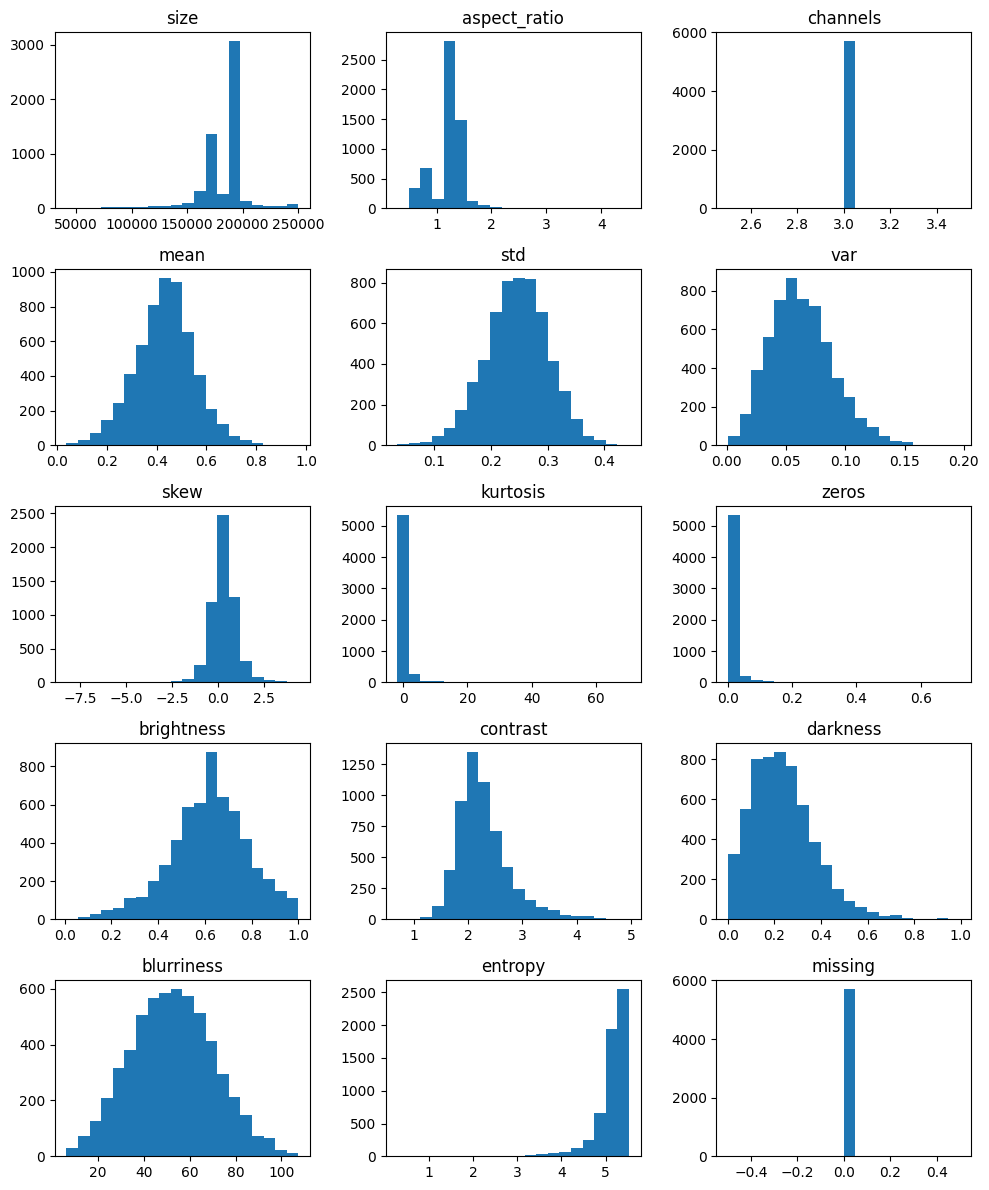

In [11]:
plot_metric_histogram(log=False)

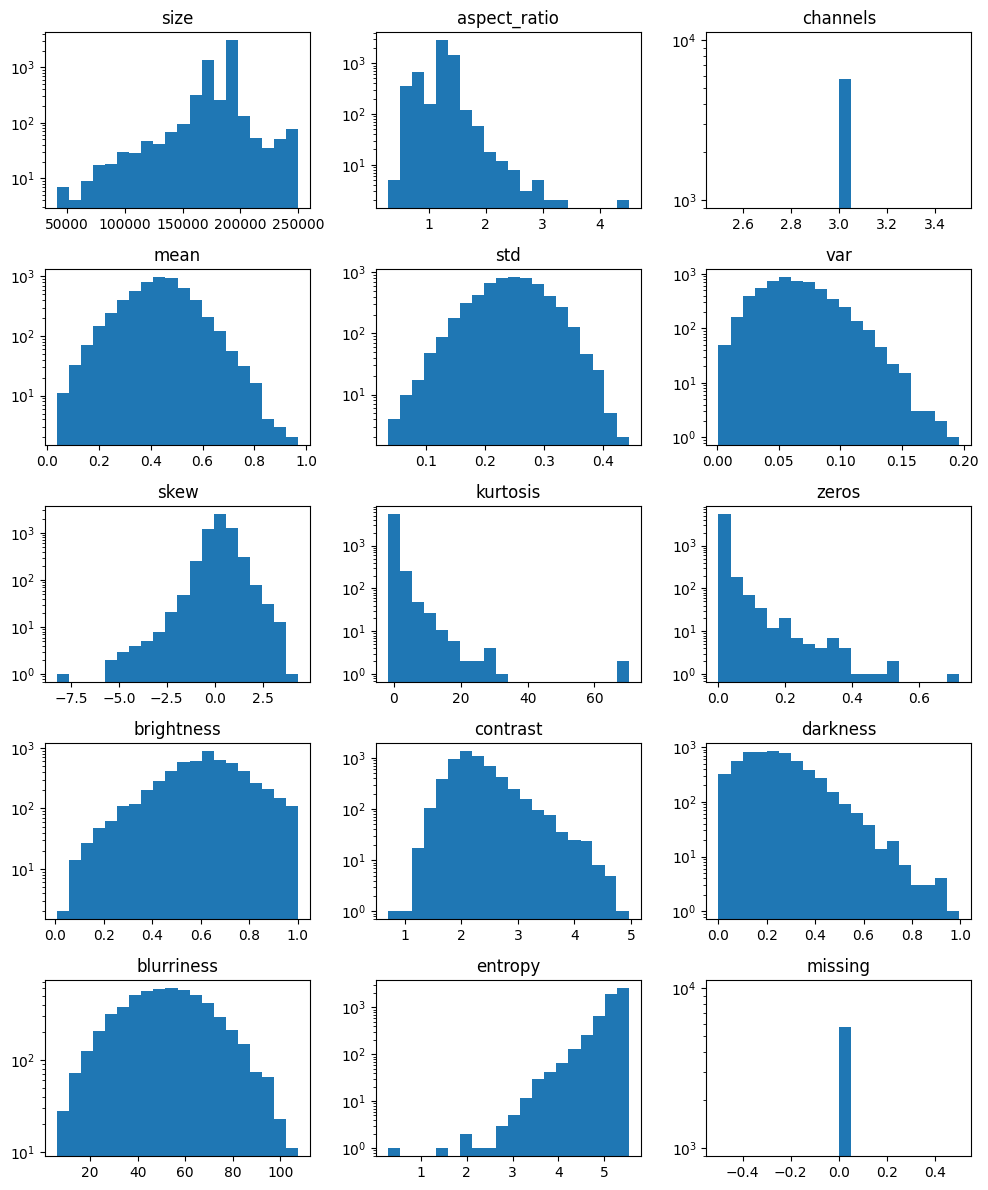

In [12]:
plot_metric_histogram(log=True)

In [13]:
# This cell takes about 1-3 minutes to run depending on your hardware

# Calculate the per-channel pixelstats and visualstats for the images
# Note: the stat functions expect the images as an iterable and in the (C,H,W) format
ch_stats = channelstats(d[0] for d in ds)

# Aggregate all of the results in a single dictionary
ds_channel_stats = ch_stats.dict()

# View the list of metrics in the channel stats class
list(ds_channel_stats)

['source_index',
 'box_count',
 'mean',
 'std',
 'var',
 'skew',
 'kurtosis',
 'histogram',
 'entropy',
 'brightness',
 'blurriness',
 'contrast',
 'darkness',
 'missing',
 'zeros',
 'percentiles']

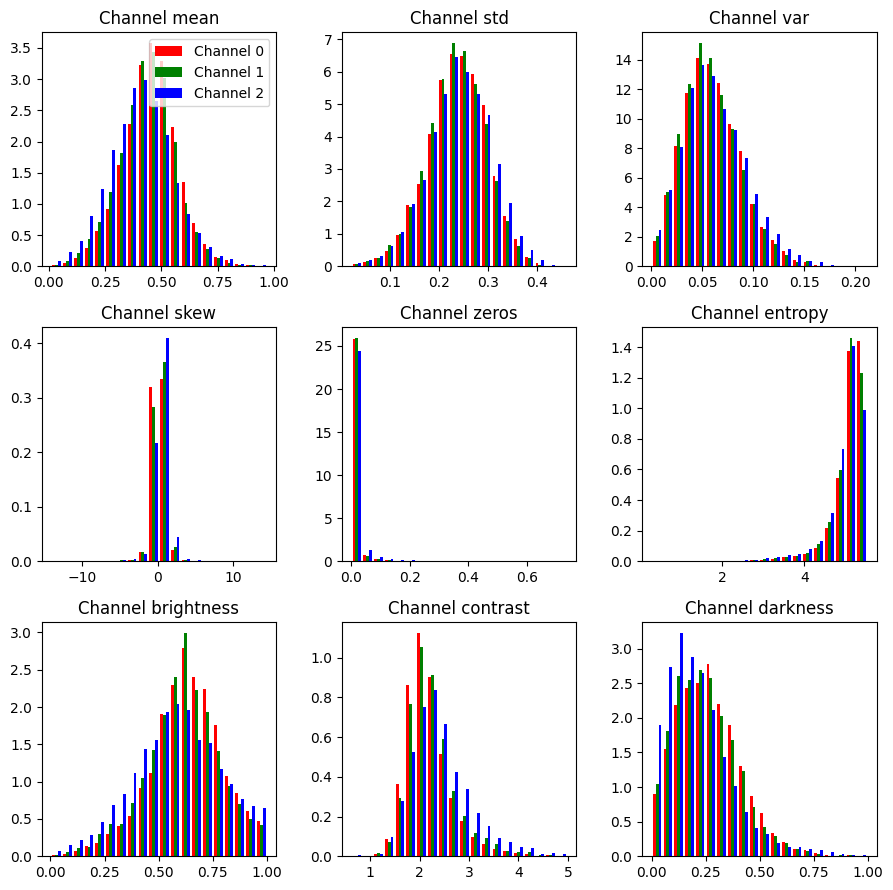

In [14]:
ch_mask = ch_stats.pixelstats.get_channel_mask(None, 3)
_, axs = plt.subplots(3, 3, figsize=(9, 9))
label_kwarg = {"label": ["Channel 0", "Channel 1", "Channel 2"]}

for ax, metric in zip(
    axs.flat,
    [
        "mean",
        "std",
        "var",
        "skew",
        "zeros",
        "entropy",
        "brightness",
        "contrast",
        "darkness",
    ],
):
    # Plot the histogram for the chosen metric
    # Since each image has 3 channels, a reshape is needed for matplotlib
    # because matplotlib treats the # of columns as different datasets
    ax.hist(
        ds_channel_stats[metric][ch_mask].reshape(-1, 3),
        bins=20,
        density=True,
        color=["red", "green", "blue"],
        **label_kwarg,
    )
    ax.set_title(f"Channel {metric}")

    # Set label for first chart only
    if label_kwarg:
        ax.legend()
        label_kwarg = {}

plt.tight_layout()
plt.show()

In [15]:
# Initialize the Outliers class
outliers = Outliers(outlier_method="zscore")

# Find the extreme images
outlier_imgs = outliers.from_stats(stats)

# View the number of extreme images
print(f"Number of images with extreme values: {len(outlier_imgs)}")

Number of images with extreme values: 498


In [16]:
# List the metrics with an extreme value
metrics = {}
for img, group in outlier_imgs.issues.items():
    for extreme in group:
        if extreme in metrics:
            metrics[extreme].append(img)
        else:
            metrics[extreme] = [img]
print(f"Number of metrics with extremes: {len(metrics)}")

# Show the total number of extreme values for each metric
for group, imgs in sorted(metrics.items(), key=lambda item: len(item[1]), reverse=True):
    print(f"  {group} - {len(imgs)}")

Number of metrics with extremes: 15
  size - 173
  entropy - 123
  zeros - 100
  contrast - 92
  skew - 89
  kurtosis - 73
  darkness - 52
  width - 43
  var - 35
  aspect_ratio - 33
  mean - 29
  std - 22
  height - 22
  brightness - 20
  blurriness - 2


In [17]:
# Show each metric by class
# Determine which classes are present in each image
class_wise = {obj: {} for obj in sorted(lstats.image_indices_per_label)}
for group, imgs in metrics.items():
    for img in imgs:
        unique_items = set(labels[img])
        for cat in unique_items:
            if group not in class_wise[cat]:
                class_wise[cat][group] = 0
            class_wise[cat][group] += 1

# Create the table for displaying
table_header = ["      Class"]
for group in sorted(metrics.keys()):
    table_header.append(f"{group:^10}")
table_header.append("  Total")
table = [table_header]
for class_cat, results in class_wise.items():
    table_rows = [f"{class_cat:>11}"]
    total = 0
    for group in sorted(metrics.keys()):
        if group == "aspect_ratio":
            if group in results:
                table_rows.append(f"{results[group]:^12}")
                total += results[group]
            else:
                table_rows.append(f"{0:^12}")
        else:
            if group in results:
                table_rows.append(f"{results[group]:^10}")
                total += results[group]
            else:
                table_rows.append(f"{0:^10}")
    table_rows.append(f"  {total:^5}")
    table.append(table_rows)

In [18]:
# Display the table
for row in table:
    print(" | ".join(row))

      Class | aspect_ratio | blurriness | brightness |  contrast  |  darkness  |  entropy   |   height   |  kurtosis  |    mean    |    size    |    skew    |    std     |    var     |   width    |   zeros    |   Total
  aeroplane |      7       |     0      |     2      |     4      |     22     |     28     |     5      |     23     |     7      |     12     |     30     |     6      |     1      |     1      |     2      |    150 
    bicycle |      0       |     0      |     0      |     3      |     1      |     3      |     0      |     2      |     1      |     10     |     3      |     0      |     0      |     5      |     3      |    31  
       bird |      3       |     0      |     1      |     3      |     8      |     16     |     1      |     12     |     1      |     10     |     14     |     5      |     0      |     1      |     9      |    84  
       boat |      7       |     0      |     1      |     2      |     2      |     6      |     4      |     2      |     

In [19]:
# Helper method to plot images of interest
def plot_sample_images(metric: str, layout: tuple[int, int]) -> None:
    _, axs = plt.subplots(*layout, figsize=(12, 10))
    selected_index = rng.choice(metrics[metric], min(np.prod(layout), len(metrics[metric])), replace=False)

    for i, ax in enumerate(axs.flat):
        ax.imshow(get_image(selected_index[i]))
        ax.set_title(f"{metric}={np.round(dataset_stats[metric][selected_index[i]], 2)}")
        ax.axis("off")

    print(f"metric={metric}")
    print(f"quantiles={np.round(np.quantile(dataset_stats[metric], [0, 0.25, 0.5, 0.75, 1]), 2)}")
    plt.tight_layout()
    plt.show()

metric=entropy
quantiles=[0.28 5.05 5.23 5.36 5.53]


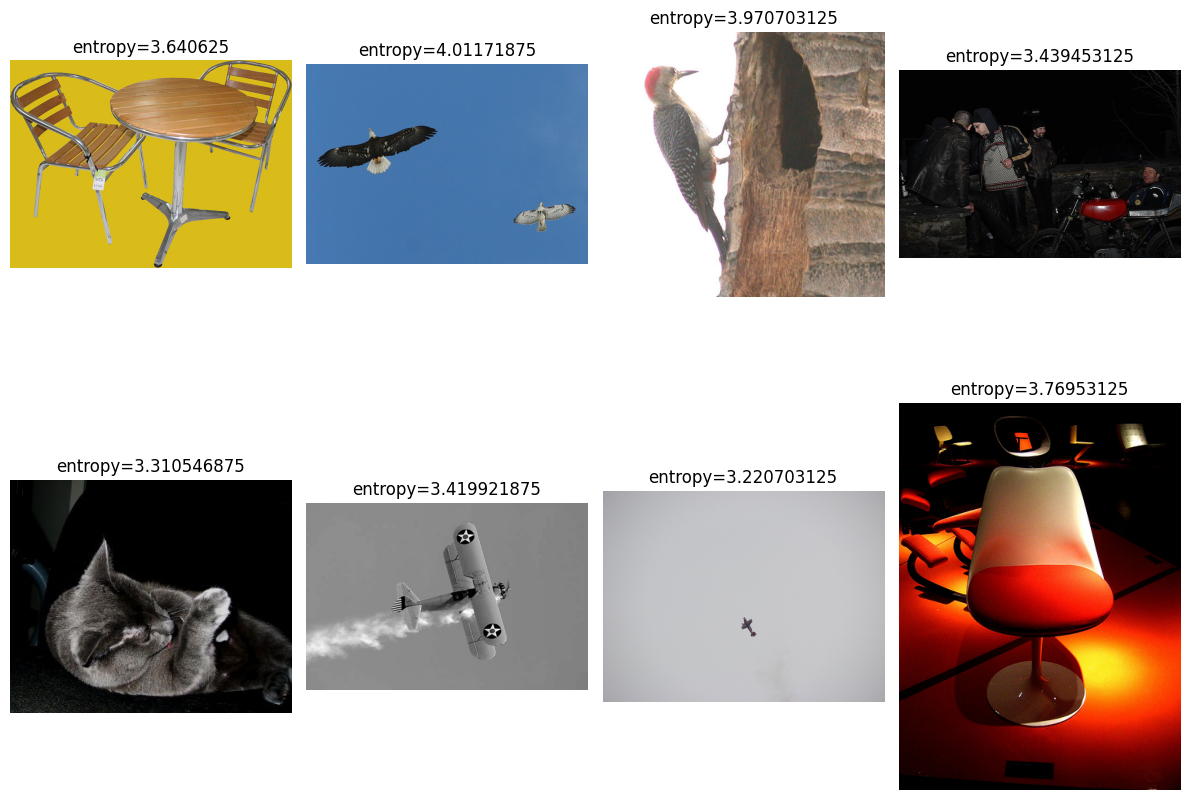

In [20]:
# Plot images flagged for "entropy"
plot_sample_images("entropy", (2, 4))

metric=size
quantiles=[ 41250. 166500. 187500. 187500. 250000.]


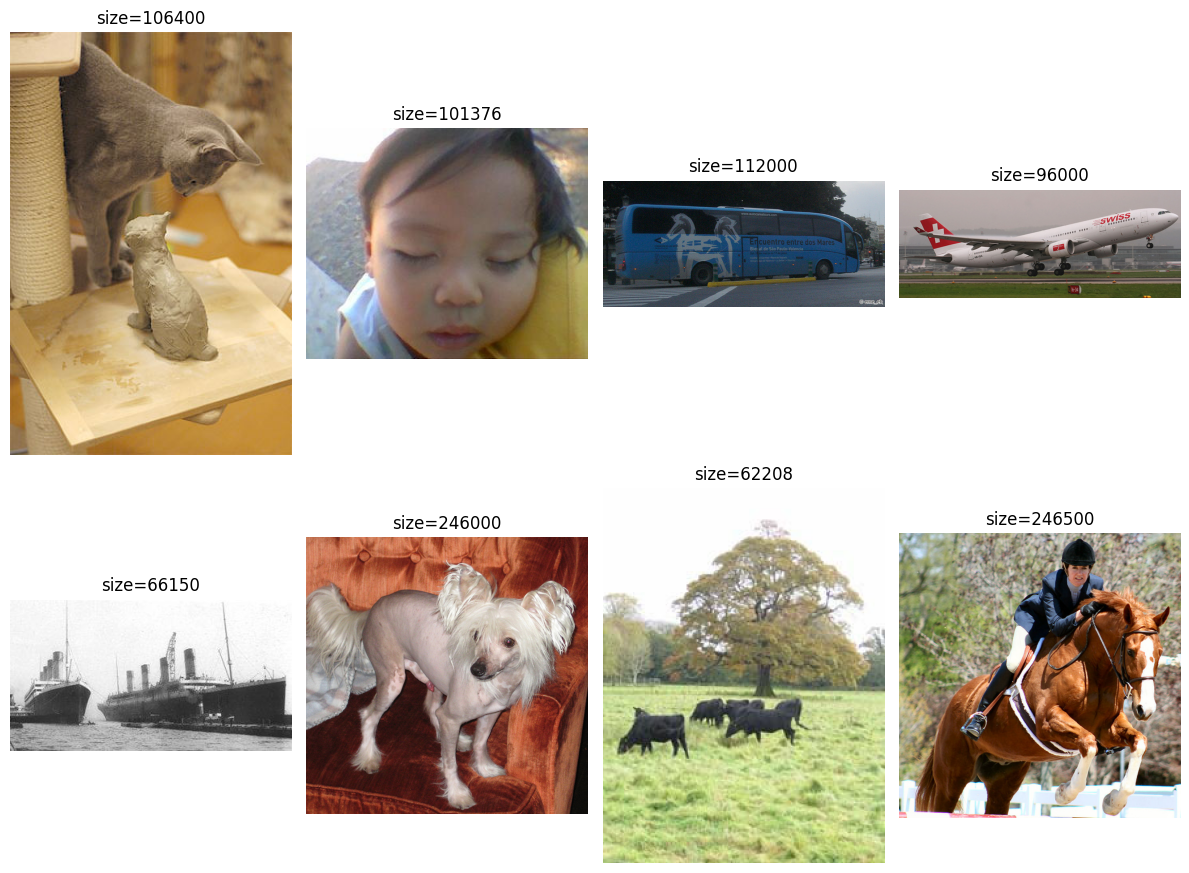

In [21]:
# Plot images flagged for "size"
plot_sample_images("size", (2, 4))

metric=zeros
quantiles=[0.   0.   0.   0.01 0.72]


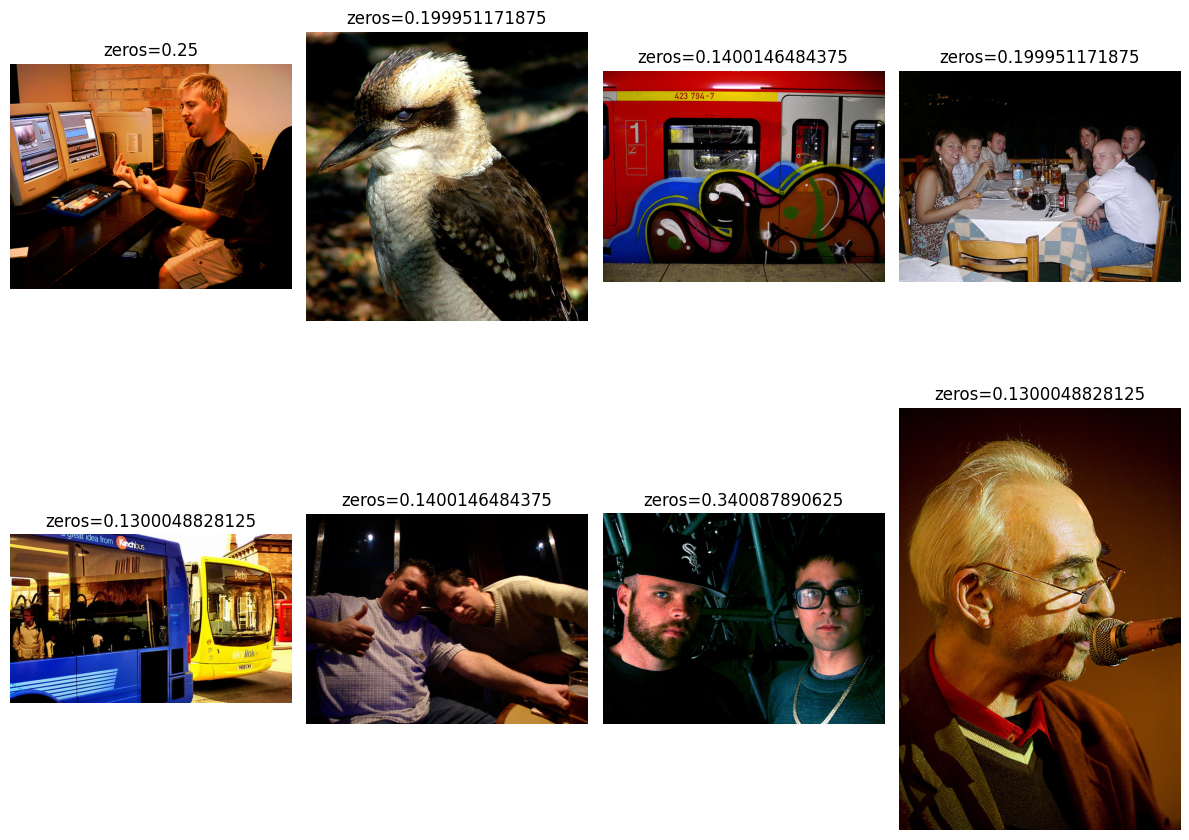

In [22]:
# Plot images flagged for "zeros"
plot_sample_images("zeros", (2, 4))

metric=blurriness
quantiles=[  6.11  39.66  52.41  64.94 107.38]


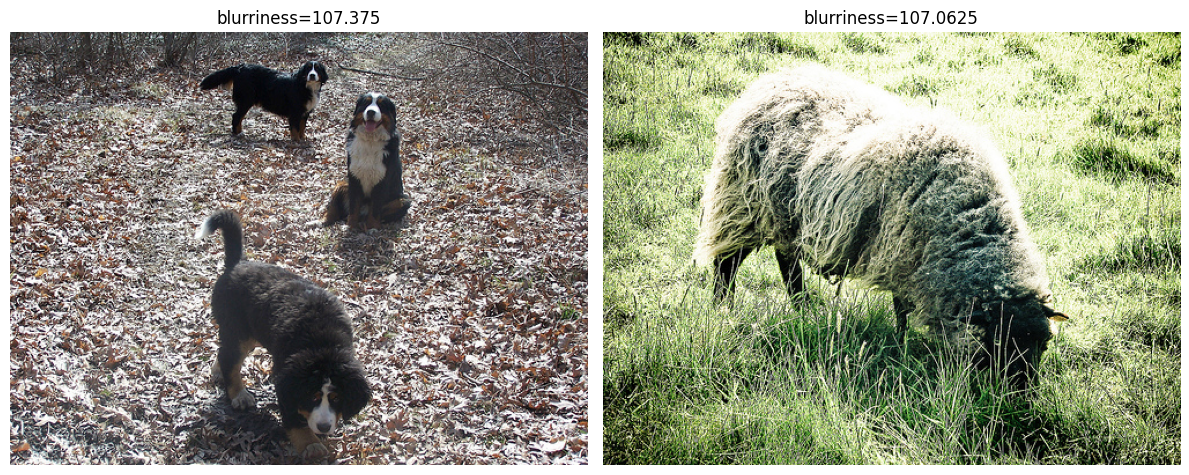

In [23]:
# Plot images flagged for "blurriness"
plot_sample_images("blurriness", (1, 2))

In [24]:
# Initialize the Duplicates class
dups = Duplicates()

# Find the duplicates
dups.evaluate(d[0] for d in ds)

DuplicatesOutput(exact=[], near=[])

In [25]:
# Create exact and duplicate images

# Copy images 23 and 46 to create exact duplicates
# Copy and crop images 5 and 4376 to create near duplicates
dupes = [
    ds[23][0],
    ds[46][0],
    ds[5][0][:, 5:-5, 5:-5],
    ds[4376][0][:, :-5, 5:],
]

dupes_stats = hashstats(dupes)

In [26]:
# Find the duplicates appended to the dataset
duplicates = dups.from_stats([dups.stats, dupes_stats])
print(f"exact: {duplicates.exact}")
print(f"near: {duplicates.near}")

exact: [{0: [23], 1: [0]}, {0: [46], 1: [1]}]
near: [{0: [5], 1: [2]}, {0: [4376], 1: [3]}]
